In [ ]:
import sys
sys.path.append('.')
sys.path.append('..')

import pandas as pd
import os
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from src.utils import helper
from src import constants as const
import torch
import glob

type_mapping = {
    "asphalt": 0,
    "concrete": 1,
    "paving_stones": 2,
    "sett": 3,
    "unpaved": 4
}

# Flattened dfiction mapping from constants
FLATTENED_INT = {
    "asphalt__excellent": 0,
    "asphalt__good": 1,
    "asphalt__intermediate": 2,
    "asphalt__bad": 3,
    "concrete__excellent": 4,
    "concrete__good": 5, 
    "concrete__intermediate": 6, 
    "concrete__bad": 7, 
    "paving_stones__excellent": 8,
    "paving_stones__good": 9, 
    "paving_stones__intermediate": 10, 
    "paving_stones__bad": 11, 
    "sett__good": 12, 
    "sett__intermediate": 13, 
    "sett__bad": 14, 
    "unpaved__intermediate": 15, 
    "unpaved__bad": 16, 
    "unpaved__very_bad": 17,
}



In [2]:
head = const.CORN
ds_version = "V1_0"
ds_type = "test"
only_validation = False
root_data = r"C:\Users\esthe\Documents\GitHub\classification_models\data\training"
level = const.CC
root_predict = os.path.join(root_data, "prediction", "Esther_MA")
annotations_file = "streetSurfaceVis_v1_0.csv"
base_file = "surface-vgg16-classification-CC-20241111_131956-1fer2zyn42_epoch11.pt-corn-V1_0-test-20241123_141223-.csv"
file_name = base_file.split('V1_0', 1)[0]
# file_pattern =  os.path.join(root_predict, f"{base_file}-*.csv")
# file_paths = glob.glob(file_pattern)
# dfs = [pd.read_csv(file) for file in file_paths]
pred = pd.read_csv(os.path.join(root_predict, base_file))
results_file = f"results_{base_file}.csv"

prediction_path = os.path.join(root_predict)
os.makedirs(prediction_path, exist_ok=True)

data_path = os.path.join(root_data, ds_version)
os.makedirs(data_path, exist_ok=True)

results_path = os.path.join(prediction_path, "results_metrics")
os.makedirs(results_path, exist_ok=True)
#data_path = os.path.join(root_data_path, "metadata")
pred

,Image,Prediction,Level,is_in_validation,Level_0,Level_1,Seed
0,1001609044211988,7.762904715491459e-05,type,0,asphalt,NaN,NaN
1,1001609044211988,0.00046925150672905147,type,0,concrete,NaN,NaN
2,1001609044211988,2.5832669052761048e-05,type,0,paving_stones,NaN,NaN
3,1001609044211988,1.7645068510319106e-05,type,0,sett,NaN,NaN
4,1001609044211988,0.9994096755981445,type,0,unpaved,NaN,NaN
...,...,...,...,...,...,...,...
4651,953155329133555,intermediate,quality,0,unpaved,['unpaved'],NaN
4652,960235968377709,intermediate,quality,0,unpaved,['unpaved'],NaN
4653,979077926660808,very_bad,quality,0,unpaved,['unpaved'],NaN
4654,983660748985366,bad,quality,0,unpaved,['unpaved'],NaN


In [3]:
#Combine different seed files in one df
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_label_pred"}, inplace=True)
pred

,image_id,Prediction,Level,is_in_validation,type_pred,quality_label_pred,Seed
0,1001609044211988,7.762904715491459e-05,type,0,asphalt,NaN,NaN
1,1001609044211988,0.00046925150672905147,type,0,concrete,NaN,NaN
2,1001609044211988,2.5832669052761048e-05,type,0,paving_stones,NaN,NaN
3,1001609044211988,1.7645068510319106e-05,type,0,sett,NaN,NaN
4,1001609044211988,0.9994096755981445,type,0,unpaved,NaN,NaN
...,...,...,...,...,...,...,...
4651,953155329133555,intermediate,quality,0,unpaved,['unpaved'],NaN
4652,960235968377709,intermediate,quality,0,unpaved,['unpaved'],NaN
4653,979077926660808,very_bad,quality,0,unpaved,['unpaved'],NaN
4654,983660748985366,bad,quality,0,unpaved,['unpaved'],NaN


In [4]:
quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_label_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)
if only_validation:
    quality_pred = quality_pred[quality_pred["is_in_validation"] == 1]
quality_pred

,image_id,quality_float_pred,quality_label_pred,is_in_validation
3880,1001729437616660,bad,['asphalt'],0
3881,1003320543995770,intermediate,['asphalt'],0
3882,1003492640340054,intermediate,['asphalt'],0
3883,1005619040188548,intermediate,['asphalt'],0
3884,1010042780007750,intermediate,['asphalt'],0
...,...,...,...,...
4651,953155329133555,intermediate,['unpaved'],0
4652,960235968377709,intermediate,['unpaved'],0
4653,979077926660808,very_bad,['unpaved'],0
4654,983660748985366,bad,['unpaved'],0


In [5]:
if head == const.CORN or head == const.REGRESSION:
    quality_pred['flattened_prediction'] = quality_pred['quality_label_pred'].astype(str).str.replace(r"['\[\]]", "", regex=True) + '__' + quality_pred['quality_float_pred'].astype(str).str.replace(r"['\[\]]", "", regex=True)
    quality_pred['flattened_prediction_int'] = quality_pred['flattened_prediction'].map(FLATTENED_INT_PRED)
    quality_pred['coarse_prediction'] = quality_pred['quality_label_pred'].astype(str).str.replace(r"['\[\]]", "", regex=True)
    quality_pred['type_prediction_int'] = quality_pred['coarse_prediction'].map(type_mapping)
    
pred_combined = quality_pred

In [6]:
if head == const.CLASSIFICATION or head == const.CLM:
    type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
    type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
    idx = type_pred.groupby("image_id")["class_prob"].idxmax()
    type_pred = type_pred.loc[idx]
    type_pred

In [7]:
quality_pred["image_id"] = quality_pred["image_id"].astype("int64")
quality_pred["is_in_validation"] = quality_pred["is_in_validation"].astype("int64")


if head == const.CLASSIFICATION or head == const.CLM:

    type_pred["image_id"] = type_pred["image_id"].astype("int64")
    type_pred["is_in_validation"] = type_pred["is_in_validation"].astype("int64")

    print(quality_pred['image_id'].dtype)
    print(type_pred['image_id'].dtype)

    pred = pd.merge(
        quality_pred, 
        type_pred, 
        on="image_id", 
        how="inner", 
        suffixes=('_quality', '_type')
    )

    #pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")
    #pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")
    pred['image_id'] = pred['image_id'].astype(str)
    pred_combined = pred


In [8]:
if head == const.CLASSIFICATION or head == const.CLM:
    idx_quality = pred.groupby("image_id")["quality_float_pred"].idxmax()
    pred_combined = pred.loc[idx_quality]

    
pred_combined['image_id'] = pred_combined['image_id'].astype(str)

pred_combined

,image_id,quality_float_pred,quality_label_pred,is_in_validation,flattened_prediction,flattened_prediction_int,coarse_prediction,type_prediction_int
3880,1001729437616660,bad,['asphalt'],0,asphalt__bad,2,asphalt,0
3881,1003320543995770,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0
3882,1003492640340054,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0
3883,1005619040188548,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0
3884,1010042780007750,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0
...,...,...,...,...,...,...,...,...
4651,953155329133555,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4
4652,960235968377709,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4
4653,979077926660808,very_bad,['unpaved'],0,unpaved__very_bad,16,unpaved,4
4654,983660748985366,bad,['unpaved'],0,unpaved__bad,15,unpaved,4


In [9]:
annot = pd.read_csv(os.path.join(data_path, "metadata", annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
#annot["type_float_true"] = annot["type_true"].map({"asphalt": 0, "concrete": 2, "paving_stones": 3, "sett": 4, "unpaved": 5})
#annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})
#annot["fine_true"] = annot.apply(lambda row: helper.flattened_mapping_true.get((row["type_true"], row["quality_label_true"]), -1), axis=1)
#annot["fine_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

# Check for any unmatched combinations (they will have -1 as their flattened label)
# unmatched = annot[annot["fine_true"] == -1]
# if not unmatched.empty:
#     print("Warning: Found unmatched (type, quality) pairs:")
#     print(unmatched[["type_true", "quality_label_true"]])

# Convert the flattened labels to tensor if needed
#flattened_labels_tensor = torch.tensor(annot["fine_true"].values, dtype=torch.long)
print(annot)
#annot = annot.reset_index()
# pred_combined = pred_combined.reset_index()
annot['image_id'] = annot['image_id'].astype(str)

              image_id          user_id   user_name    captured_at  longitude  \
0     1000927687276860  103606985215406        dsmm  1655735677353  13.287805   
1     1001349260556407  102468835332129      ber319  1659015876793  14.426536   
2     1001419624308587  100232345559807   carlheinz  1698249177500  13.457938   
3     1001712924422413  100232345559807   carlheinz  1699107239000  13.386874   
4     1001853784055707  102627028648372   kartonage  1652268883000  13.389880   
...                ...              ...         ...            ...        ...   
9117   435956961754271  103080845264750     teddy73  1657610360090   9.227063   
9118   152523294419317  103080845264750     teddy73  1681130193000   9.179631   
9119   303366287999275  100562292188203  changchun1  1612977717350   9.172729   
9120   563555448482947  100562292188203  changchun1  1654801255232   9.176029   
9121  1068388274103113  103080845264750     teddy73  1656260065000   9.148292   

       latitude  train type

In [10]:
annot.set_index('image_id', inplace=True)
pred_combined.set_index('image_id', inplace=True)
df = pred_combined.join(
    annot[["type_true", "quality_label_true", "train"]], how="left")

df.rename(columns={"type_pred": "type_prediction", "quality_label_pred": "quality_prediction"}, inplace=True)
df

,quality_float_pred,quality_prediction,is_in_validation,flattened_prediction,flattened_prediction_int,coarse_prediction,type_prediction_int,type_true,quality_label_true,train
image_id,,,,,,,,,,
1001729437616660,bad,['asphalt'],0,asphalt__bad,2,asphalt,0,paving_stones,intermediate,False
1003320543995770,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False
1003492640340054,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False
1005619040188548,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,excellent,False
1010042780007750,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False
...,...,...,...,...,...,...,...,...,...,...
953155329133555,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4,unpaved,bad,False
960235968377709,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4,unpaved,bad,False
979077926660808,very_bad,['unpaved'],0,unpaved__very_bad,16,unpaved,4,unpaved,bad,False


In [11]:
if head == const.CLASSIFICATION or head == const.CLM:
    df["flattened_prediction"] = df['type_prediction'] + '__' + df['quality_prediction']
    df["flattened_prediction_int"] = df["flattened_prediction"].map(FLATTENED_INT_PRED)
    df["type_prediction_int"] = df["type_prediction"].map(type_mapping)
    
df["flattened_true"] = df['type_true'] + '__' + df['quality_label_true']
df["type_true_int"] = df["type_true"].map(type_mapping)
df["flattened_true_int"] = df["flattened_true"].map(FLATTENED_INT)

df

,quality_float_pred,quality_prediction,is_in_validation,flattened_prediction,flattened_prediction_int,coarse_prediction,type_prediction_int,type_true,quality_label_true,train,flattened_true,type_true_int,flattened_true_int
image_id,,,,,,,,,,,,,
1001729437616660,bad,['asphalt'],0,asphalt__bad,2,asphalt,0,paving_stones,intermediate,False,paving_stones__intermediate,2,10
1003320543995770,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False,asphalt__good,0,1
1003492640340054,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False,asphalt__good,0,1
1005619040188548,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,excellent,False,asphalt__excellent,0,0
1010042780007750,intermediate,['asphalt'],0,asphalt__intermediate,1,asphalt,0,asphalt,good,False,asphalt__good,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
953155329133555,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4,unpaved,bad,False,unpaved__bad,4,16
960235968377709,intermediate,['unpaved'],0,unpaved__intermediate,17,unpaved,4,unpaved,bad,False,unpaved__bad,4,16
979077926660808,very_bad,['unpaved'],0,unpaved__very_bad,16,unpaved,4,unpaved,bad,False,unpaved__bad,4,16


In [12]:
df.groupby(["type_true", "quality_label_true"]).size()

type_true      quality_label_true
asphalt        bad                     8
               excellent             180
               good                  289
               intermediate           53
concrete       excellent               4
               good                   10
               intermediate            2
paving_stones  excellent              25
               good                   74
               intermediate           14
sett           bad                    14
               good                    1
               intermediate           17
unpaved        bad                    48
               intermediate           21
               very_bad               16
dtype: int64

In [13]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": root_mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [14]:
# merged_dfs = {}

# # Ensure `image_id` is of the same type in both DataFrames
# annot["image_id"] = annot["image_id"].astype(int)


# df["image_id"] = df["image_id"].astype(int)
# # Filter `annot` to only include rows with `image_id`s that are in `df`
# filtered_annot = annot[annot["image_id"].isin(df["image_id"])]

# # Perform a left join on `image_id`, retaining only the rows in `df`
# merged_df = df.merge(
#     filtered_annot[["image_id", "fine_true", "type_true", "quality_label_true"]], 
#     on="image_id", 
#     how="inner"
# )
merged_df = df
merged_df = merged_df.dropna(subset=["flattened_true_int", "flattened_prediction_int"])

print(f"Final df shape :", merged_df.shape)
print(merged_df.head())

Final df shape : (776, 13)
                 quality_float_pred quality_prediction  is_in_validation  \
image_id                                                                   
1001729437616660                bad        ['asphalt']                 0   
1003320543995770       intermediate        ['asphalt']                 0   
1003492640340054       intermediate        ['asphalt']                 0   
1005619040188548       intermediate        ['asphalt']                 0   
1010042780007750       intermediate        ['asphalt']                 0   

                   flattened_prediction  flattened_prediction_int  \
image_id                                                            
1001729437616660           asphalt__bad                         2   
1003320543995770  asphalt__intermediate                         1   
1003492640340054  asphalt__intermediate                         1   
1005619040188548  asphalt__intermediate                         1   
1010042780007750  asphalt_

In [15]:
print("Dtype of 'flattened_true_int':", merged_df["flattened_true_int"].dtype)
print("Dtype of 'flattened_prediction_int':", merged_df["flattened_prediction_int"].dtype)
# Convert to integer
merged_df["flattened_prediction_int"] = merged_df["flattened_prediction_int"].astype(int)


Dtype of 'flattened_true_int': int64
Dtype of 'flattened_prediction_int': int64


In [16]:
def calculate_metrics(merged_df, true, pred):
    # Custom metrics calculations
    metrics = {
        "coarse accuracy": sum(merged_df['type_true_int'] == merged_df['type_prediction_int'])  / len(merged_df['type_true_int']),
        "fine accuracy": sum(true == pred) / len(true),
        "fine accuracy within": sum(merged_df["quality_prediction"] == merged_df["quality_label_true"]) / len(merged_df["quality_label_true"]),
        "fine accuracy_one_off": np.mean(np.abs(true - pred) <= 1),  # Absolute difference for one-off accuracy
        "mse": root_mean_squared_error(true, pred),
        "mae": mean_absolute_error(true, pred),
        "qwk": cohen_kappa_score(true, pred, weights="quadratic"),
        "hv": np.mean(helper.is_hierarchy_violation_batch(true, pred, helper.parent)),
        "precision": precision_score(true, pred, average="weighted", zero_division=0),
        "recall": recall_score(true, pred, average="weighted", zero_division=0),
        "f1_score": f1_score(true, pred, average="weighted", zero_division=0)
    }
    
    # Add classification report metrics
    report = classification_report(true, pred, output_dict=True, zero_division=0)
    for metric, value in report['weighted avg'].items():
        metrics[f"classification_{metric}"] = value  # Prefix to distinguish from custom metrics
    
    return metrics


# Calculate overall metrics
all_metrics = {}

# Overall metrics for the entire DataFrame
overall_metrics = calculate_metrics(merged_df, merged_df["flattened_true_int"], merged_df["flattened_prediction_int"])
overall_metrics["surface_type"] = "overall"
all_metrics["overall"] = overall_metrics

# Per-surface type metrics by grouping on `type_true`
if level == const.HIERARCHICAL or level == const.CC:
    for surface_type, group in merged_df.groupby("type_true"):
        surface_metrics = calculate_metrics(group, group["flattened_true_int"], group["flattened_prediction_int"])
        surface_metrics["type_true"] = surface_type
        all_metrics[surface_type] = surface_metrics
        
final_metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index').reset_index()


In [17]:
final_metrics_df

,index,coarse accuracy,fine accuracy,fine accuracy within,fine accuracy_one_off,mse,mae,qwk,hv,precision,recall,f1_score,classification_precision,classification_recall,classification_f1-score,classification_support,surface_type,type_true
0,overall,0.873711,0.452320,0.0,0.844072,2.887718,1.261598,0.863057,0.126289,0.508790,0.452320,0.469984,0.508790,0.452320,0.469984,776.0,overall,NaN
1,asphalt,0.864151,0.477358,0.0,0.839623,2.824088,1.224528,0.092099,0.135849,0.546856,0.477358,0.508707,0.546856,0.477358,0.508707,530.0,NaN,asphalt
2,concrete,0.750000,0.375000,0.0,0.750000,4.513868,2.375000,0.241379,0.250000,0.520833,0.375000,0.403571,0.520833,0.375000,0.403571,16.0,NaN,concrete
3,paving_stones,0.902655,0.398230,0.0,0.858407,1.744777,0.991150,0.199903,0.097345,0.543246,0.398230,0.442696,0.543246,0.398230,0.442696,113.0,NaN,paving_stones
4,sett,0.906250,0.718750,0.0,0.906250,1.211920,0.531250,0.448954,0.093750,0.846354,0.718750,0.766572,0.846354,0.718750,0.766572,32.0,NaN,sett
5,unpaved,0.905882,0.282353,0.0,0.847059,4.238479,1.917647,0.131387,0.094118,0.391430,0.282353,0.309171,0.391430,0.282353,0.309171,85.0,NaN,unpaved


In [18]:
if "train" in base_file:
    if only_validation:
        save_file = f"{head}_CC_{base_file}_validation"
    else:
        save_file = f"{head}_CC_{base_file}_train"
else:
    save_file = f"{head}_CC_{base_file}_test"

In [19]:

output_path = os.path.join(results_path, f"{save_file}.csv")

final_metrics_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\corn_CC_surface-vgg16-classification-CC-20241111_131956-1fer2zyn42_epoch11.pt-corn-V1_0-test-20241123_141223-.csv_test.csv


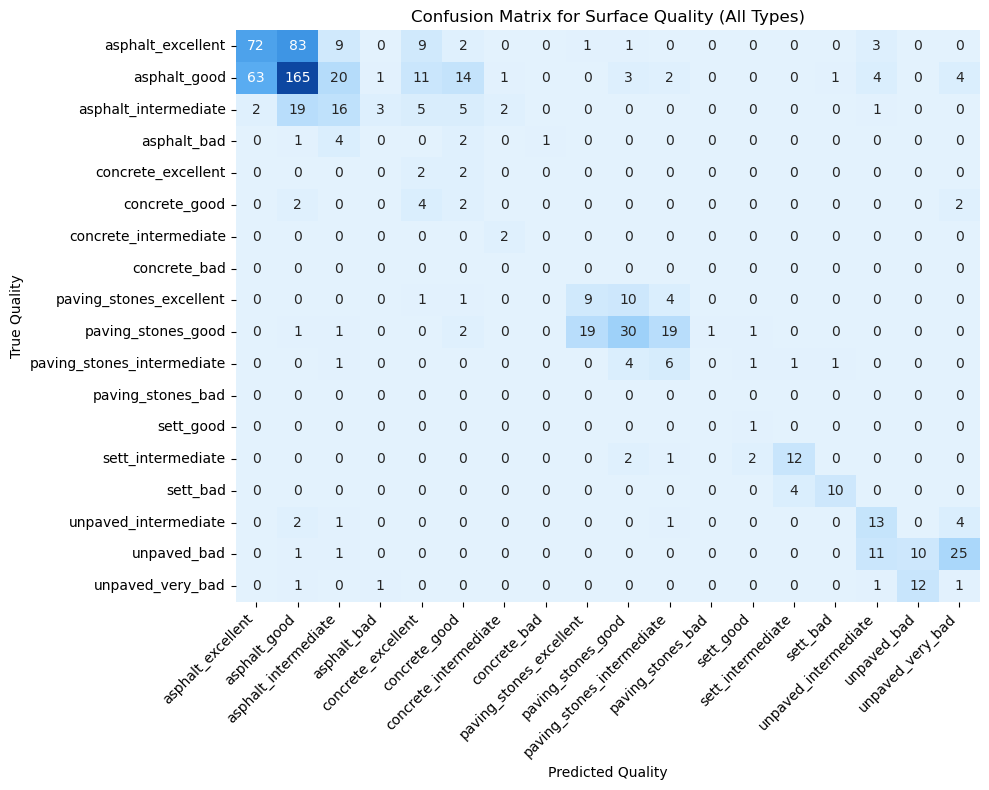

Overall confusion matrix plot saved at: C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\corn_confusion_matrix_fine_surface-vgg16-classification-CC-20241111_131956-1fer2zyn42_epoch11.pt-corn-_test.png


In [20]:
# Custom blue colormap
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["#E3F2FD", "#64B5F6", "#1976D2", "#0D47A1"])

# Define all 18 class labels
class_labels = [
    "asphalt_excellent", "asphalt_good", "asphalt_intermediate", "asphalt_bad",
    "concrete_excellent", "concrete_good", "concrete_intermediate", "concrete_bad",
    "paving_stones_excellent", "paving_stones_good", "paving_stones_intermediate", "paving_stones_bad",
    "sett_good", "sett_intermediate", "sett_bad",
    "unpaved_intermediate", "unpaved_bad", "unpaved_very_bad"
]

# Overall confusion matrix
cm = confusion_matrix(merged_df.flattened_true_int, merged_df.flattened_prediction_int, labels=range(len(class_labels)))

# Plot the overall confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=blue_cmap, cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for Surface Quality (All Types)")
plt.xlabel("Predicted Quality")
plt.ylabel("True Quality")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the overall confusion matrix
if "train" in base_file and only_validation:
    overall_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_fine_{file_name}_validation.png")
elif "train" in base_file and not only_validation:
    overall_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_fine_{file_name}_train.png")
else:
    overall_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_fine_{file_name}_test.png")

plt.savefig(overall_conf_matrix_file, transparent=True, bbox_inches='tight')
plt.show()

print(f"Overall confusion matrix plot saved at: {overall_conf_matrix_file}")

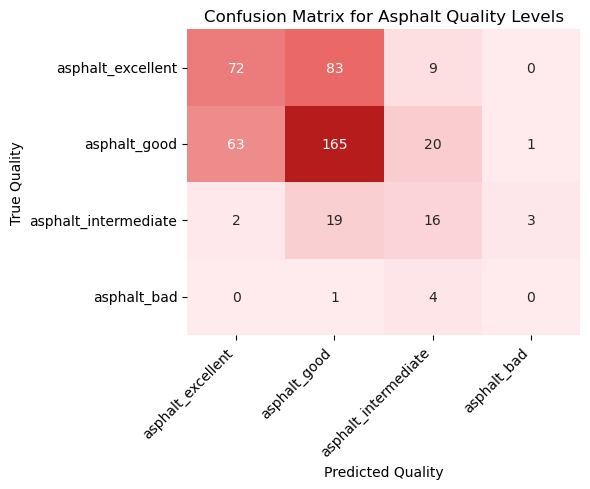

Asphalt confusion matrix plot saved at: C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\corn_confusion_matrix_asphalt_surface-vgg16-classification-CC-20241111_131956-1fer2zyn42_epoch11.pt-corn-.png


In [21]:
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFEBEE", "#EF9A9A", "#E53935", "#B71C1C"])

# Filter class labels for asphalt quality levels
asphalt_labels = ["asphalt_excellent", "asphalt_good", "asphalt_intermediate", "asphalt_bad"]
asphalt_indices = [class_labels.index(label) for label in asphalt_labels]

# Filter the confusion matrix for asphalt-related labels
asphalt_cm = confusion_matrix(
    merged_df.flattened_true_int, 
    merged_df.flattened_prediction_int, 
    labels=asphalt_indices
)

# Plot the confusion matrix for asphalt quality levels
plt.figure(figsize=(6, 5))
sns.heatmap(asphalt_cm, annot=True, fmt="d", cmap=red_cmap, cbar=False,
            xticklabels=asphalt_labels, yticklabels=asphalt_labels)
plt.title("Confusion Matrix for Asphalt Quality Levels")
plt.xlabel("Predicted Quality")
plt.ylabel("True Quality")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the asphalt confusion matrix
asphalt_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_asphalt_{file_name}.png")
plt.savefig(asphalt_conf_matrix_file, transparent=True, bbox_inches='tight')
plt.show()

print(f"Asphalt confusion matrix plot saved at: {asphalt_conf_matrix_file}")

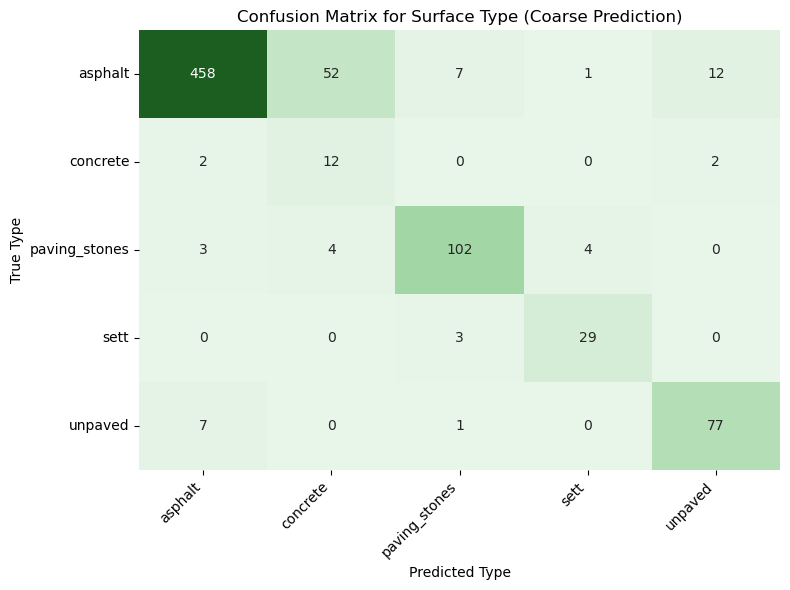

Coarse confusion matrix plot saved at: C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\corn_confusion_matrix_coarse_surface-vgg16-classification-CC-20241111_131956-1fer2zyn42_epoch11.pt-corn-_test.png


In [22]:
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["#E8F5E9", "#81C784", "#388E3C", "#1B5E20"])

# Define coarse class labels
coarse_class_labels = ["asphalt", "concrete", "paving_stones", "sett", "unpaved"]

# Compute the confusion matrix for the coarse prediction
coarse_cm = confusion_matrix(
    merged_df['type_true'], merged_df['coarse_prediction'], labels=coarse_class_labels
)

# Plot the coarse confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(coarse_cm, annot=True, fmt="d", cmap=green_cmap, cbar=False,
            xticklabels=coarse_class_labels, yticklabels=coarse_class_labels)
plt.title("Confusion Matrix for Surface Type (Coarse Prediction)")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the coarse confusion matrix
if "train" in base_file and only_validation:
    coarse_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_coarse_{file_name}_validation.png")
elif "train" in base_file and not only_validation:
    coarse_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_coarse_{file_name}_train.png")
else:
    coarse_conf_matrix_file = os.path.join(results_path, f"{head}_confusion_matrix_coarse_{file_name}_test.png")

plt.savefig(coarse_conf_matrix_file, transparent=True, bbox_inches='tight')
plt.show()

print(f"Coarse confusion matrix plot saved at: {coarse_conf_matrix_file}")

In [23]:
# type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
# type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
# type_pred#
# idx = type_pred.groupby("image_id")["class_prob"].idxmax()
# type_pred = type_pred.loc[idx]
# type_pred
